In [1]:
! pip install -q kaggle

In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/romaingraux/bitmojis/download'
od.download(dataset_url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: prikshitanthal
Your Kaggle Key: ··········


  0%|          | 0.00/1.08G [00:00<?, ?B/s]

100%|██████████| 1.08G/1.08G [00:15<00:00, 74.7MB/s]


In [4]:
import os
dir='./bitmojis'
print(os.listdir(dir)[:10])

['bitmojis']


In [5]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [6]:
image_size=64
batch_size=256
stats=(0.5,0.5,0.5),(0.5,0.5,0.5)

In [7]:
train_ds=ImageFolder(dir,transform=T.Compose([T.Resize(image_size),T.CenterCrop(image_size),T.ToTensor(),T.Normalize(*stats)]))

In [8]:
train_dl=DataLoader(train_ds,batch_size,shuffle=True,pin_memory=True,num_workers=3)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid

In [10]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


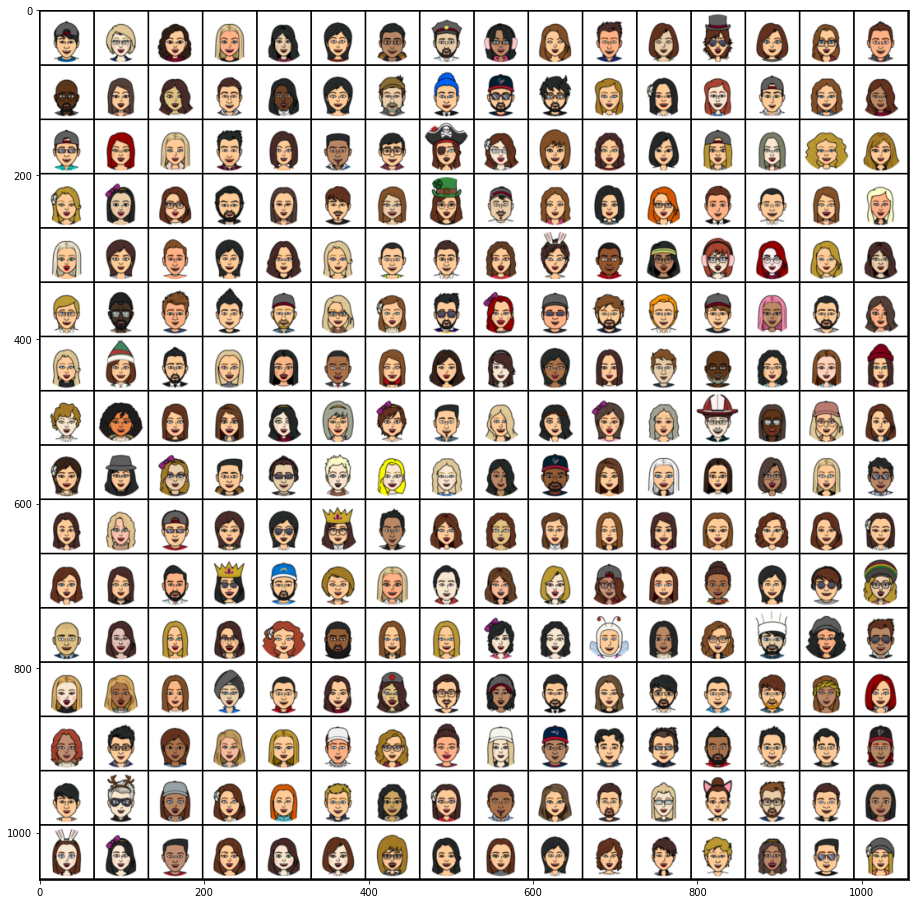

In [11]:
for images,_ in train_dl:
  fig, ax = plt.subplots(figsize=(16, 16))
  ax.imshow(make_grid(denorm(images),nrow=16).permute(1,2,0))
  break

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)

In [15]:
import torch.nn as nn
discriminator=nn.Sequential(
   nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),  #img size 64 kr dia tha top main
   nn.BatchNorm2d(64),
   nn.LeakyReLU(0.2,inplace=True),
   nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),  #img size 64 kr dia tha top main
   nn.BatchNorm2d(128),
   nn.LeakyReLU(0.2,inplace=True),
   nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),  #img size 64 kr dia tha top main
   nn.BatchNorm2d(256),
   nn.LeakyReLU(0.2,inplace=True),
   nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),  #img size 64 kr dia tha top main
   nn.BatchNorm2d(512),
   nn.LeakyReLU(0.2,inplace=True),
   nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),
   nn.Flatten(),
   nn.Sigmoid(),
)

In [16]:
discriminator = to_device(discriminator, device)

In [17]:
 latent_size=256
 generator=nn.Sequential(
 nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
  nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
     nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()  
 )


torch.Size([256, 3, 64, 64])


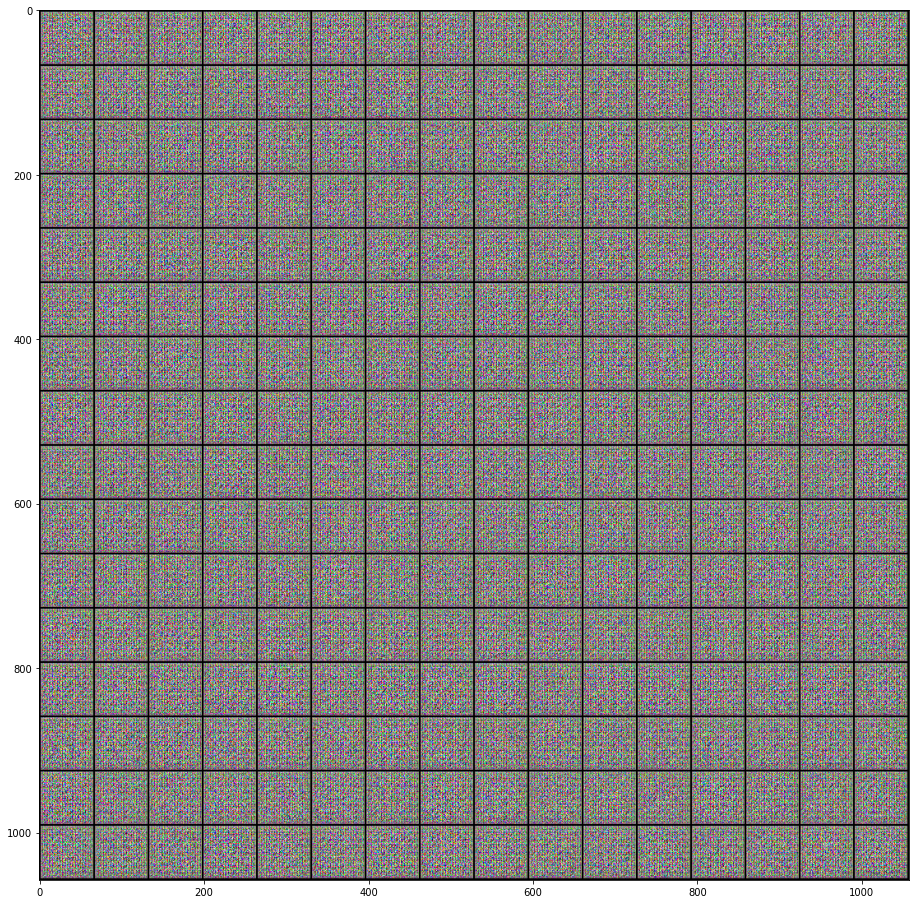

In [18]:
xb=torch.randn(batch_size,latent_size,1,1)
fake=generator(xb)
print(fake.shape)
fig,ax=plt.subplots(figsize=(16,16))
ax.imshow(make_grid(denorm(fake.detach()),nrow=16).permute(1,2,0))

In [19]:
generator = to_device(generator, device)

In [20]:
def train_discriminator(real_images,opt_d):
  opt_d.zero_grad()
  real_preds=discriminator(real_images)
  real_targets=torch.ones(real_images.size(0),1,device=device)
  real_loss=F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(),real_score,fake_score
    


In [21]:
def train_generator(opt_g):
  opt_g.zero_grad()
  latent=torch.randn(batch_size,latent_size,1,1,device=device)
  fake_images=generator(latent)

  preds=discriminator(fake_images)
  targets=torch.ones(batch_size,1,device=device)
  loss = F.binary_cross_entropy(preds, targets)

  loss.backward()
  opt_g.step()
  return loss.item()

In [22]:
from torchvision.utils import save_image
sample_dir='generated'
os.makedirs(sample_dir,exist_ok=True)


In [23]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(16, 16))
      
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=16).permute(1, 2, 0))

In [24]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


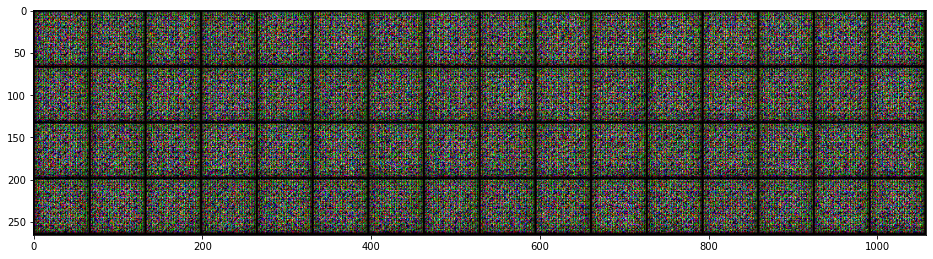

In [25]:
save_samples(0, fixed_latent)

In [26]:
from tqdm.notebook import tqdm
import torch.nn.functional as F


In [27]:
def fit(epochs,lr,start_idx=1):
  torch.cuda.empty_cache()
  losses_g=[]
  losses_d=[]
  real_scores=[]
  fake_scores=[]
  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
  for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
  return losses_g,losses_d,fake_scores,real_scores     

In [28]:
lr = 0.00005
epochs = 25

In [29]:
history = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/25], loss_g: 9.2724, loss_d: 0.5738, real_score: 0.9940, fake_score: 0.4276
Saving generated-images-0001.png



Epoch [2/25], loss_g: 3.3879, loss_d: 0.2084, real_score: 0.9253, fake_score: 0.1150
Saving generated-images-0002.png



Epoch [3/25], loss_g: 2.8373, loss_d: 0.1768, real_score: 0.9034, fake_score: 0.0656
Saving generated-images-0003.png



Epoch [4/25], loss_g: 2.7742, loss_d: 0.1678, real_score: 0.9107, fake_score: 0.0536
Saving generated-images-0004.png



Epoch [5/25], loss_g: 3.9792, loss_d: 0.1836, real_score: 0.9629, fake_score: 0.1304
Saving generated-images-0005.png



Epoch [6/25], loss_g: 4.0710, loss_d: 0.0954, real_score: 0.9616, fake_score: 0.0527
Saving generated-images-0006.png



Epoch [7/25], loss_g: 3.6204, loss_d: 0.1030, real_score: 0.9371, fake_score: 0.0305
Saving generated-images-0007.png



Epoch [8/25], loss_g: 3.3135, loss_d: 0.1174, real_score: 0.9361, fake_score: 0.0455
Saving generated-images-0008.png



Epoch [9/25], loss_g: 4.2629, loss_d: 0.0637, real_score: 0.9822, fake_score: 0.0440
Saving generated-images-0009.png



Epoch [10/25], loss_g: 3.8690, loss_d: 0.0603, real_score: 0.9626, fake_score: 0.0201
Saving generated-images-0010.png



Epoch [11/25], loss_g: 4.0720, loss_d: 0.0806, real_score: 0.9801, fake_score: 0.0561
Saving generated-images-0011.png



Epoch [12/25], loss_g: 4.2317, loss_d: 0.0499, real_score: 0.9952, fake_score: 0.0424
Saving generated-images-0012.png



Epoch [13/25], loss_g: 2.5917, loss_d: 0.2297, real_score: 0.8874, fake_score: 0.0932
Saving generated-images-0013.png



Epoch [14/25], loss_g: 6.7550, loss_d: 0.0394, real_score: 0.9894, fake_score: 0.0277
Saving generated-images-0014.png



Epoch [15/25], loss_g: 3.4093, loss_d: 0.0825, real_score: 0.9569, fake_score: 0.0347
Saving generated-images-0015.png



Epoch [16/25], loss_g: 5.0781, loss_d: 0.0316, real_score: 0.9936, fake_score: 0.0245
Saving generated-images-0016.png



Epoch [17/25], loss_g: 3.2652, loss_d: 0.0511, real_score: 0.9630, fake_score: 0.0110
Saving generated-images-0017.png



Epoch [18/25], loss_g: 4.2971, loss_d: 0.0535, real_score: 0.9702, fake_score: 0.0212
Saving generated-images-0018.png



Epoch [19/25], loss_g: 4.4349, loss_d: 0.0448, real_score: 0.9812, fake_score: 0.0246
Saving generated-images-0019.png



Epoch [20/25], loss_g: 5.2850, loss_d: 0.0410, real_score: 0.9814, fake_score: 0.0213
Saving generated-images-0020.png



Epoch [21/25], loss_g: 4.3690, loss_d: 0.0626, real_score: 0.9615, fake_score: 0.0215
Saving generated-images-0021.png



Epoch [22/25], loss_g: 5.1509, loss_d: 0.0553, real_score: 0.9899, fake_score: 0.0424
Saving generated-images-0022.png



Epoch [23/25], loss_g: 4.4351, loss_d: 0.0408, real_score: 0.9870, fake_score: 0.0265
Saving generated-images-0023.png



Epoch [24/25], loss_g: 4.7516, loss_d: 0.0429, real_score: 0.9681, fake_score: 0.0090
Saving generated-images-0024.png



Epoch [25/25], loss_g: 5.4087, loss_d: 0.0162, real_score: 0.9899, fake_score: 0.0059
Saving generated-images-0025.png


In [30]:
losses_g, losses_d, real_scores, fake_scores = history

In [31]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [32]:
from IPython.display import Image

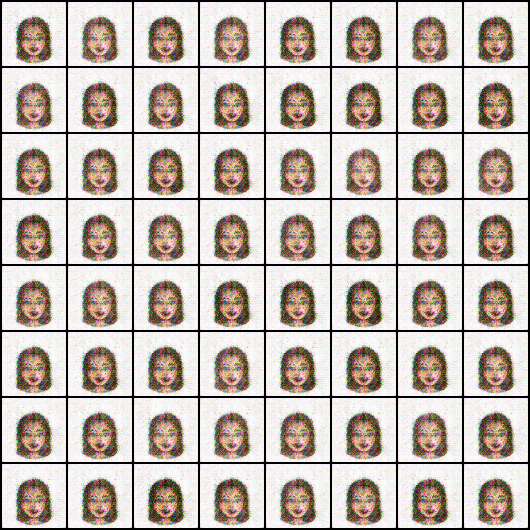

In [33]:
Image('./generated/generated-images-0001.png')

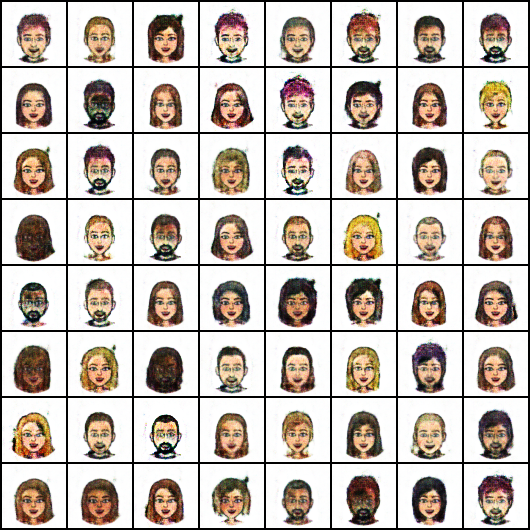

In [34]:
Image('./generated/generated-images-0005.png')

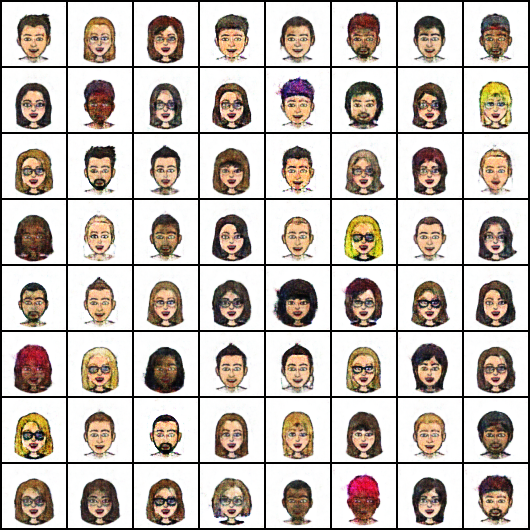

In [35]:
Image('./generated/generated-images-0010.png')

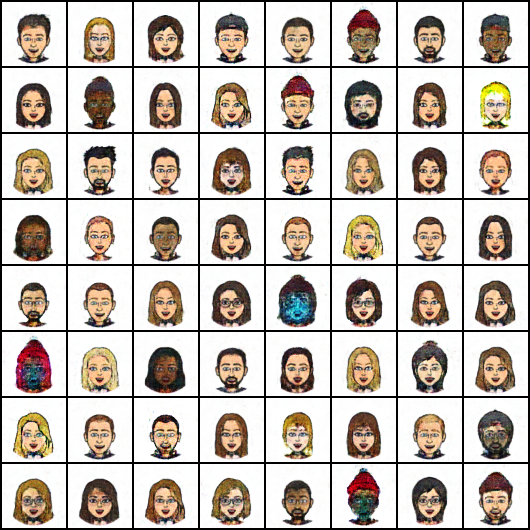

In [36]:
Image('./generated/generated-images-0020.png')

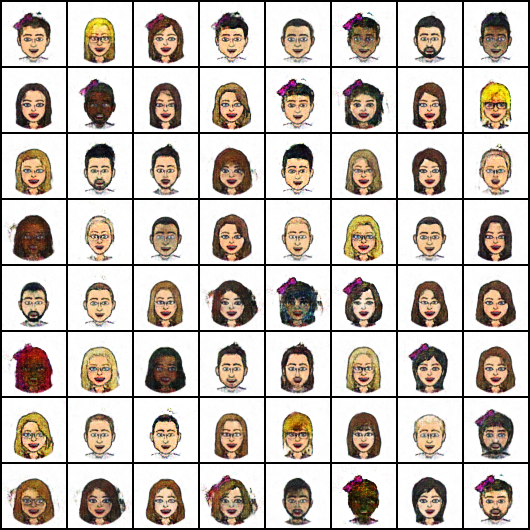

In [37]:
Image('./generated/generated-images-0025.png')

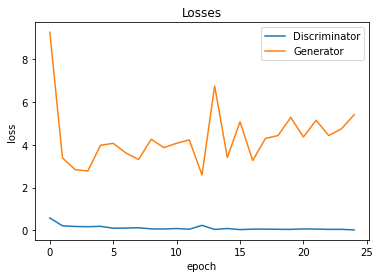

In [39]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

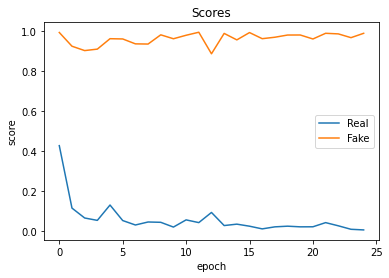

In [40]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
#FINISHED